<a href="https://colab.research.google.com/github/manda-24/Personal-Projects/blob/main/BreastCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1**: Breast Cancer Detection

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from random import sample
from PIL import Image
import timm.models.vision_transformer
from timm.layers import trunc_normal_
import math
import sys
from typing import Iterable
from timm.utils import accuracy
import datetime
import time
from collections import defaultdict, deque
import torch.distributed as dist
from torch.utils.data import DataLoader, random_split
from torch import nn
from functools import partial
import torch.nn.functional as F
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset
import re
import h5py
from torchvision.transforms import (
    Grayscale, ToTensor, Compose, Resize, InterpolationMode, Normalize, Lambda
)
plt.rcParams['font.family'] = 'serif'


**Prepare the Dataset & Identify Names of Classes** <br>
In this section, the data paths for all three classes (malignant, benign and normal) are defined. Furthermore, the class names are derived from the names of the images.

In [2]:
dataset_path = Path("/content/drive/MyDrive/Final Project/Images/Dataset_BUSI_with_GT/Masks")

In [3]:
class_names = np.array([item.name for item in dataset_path.glob('*/') if item.is_dir])
print(class_names)

['benign' 'malignant' 'normal']


In [4]:
benign_path = dataset_path/'benign'
malignant_path = dataset_path / 'malignant'
normal_path = dataset_path / 'normal'

In [5]:
Image_count = len(list(dataset_path.glob('*/*.png')))
Benign_count = len(list(benign_path.glob('*.png')))
Malignant_count = len(list(malignant_path.glob('*.png')))
Normal_count = len(list(normal_path.glob('*.png')))
print("Total Number of Images are:", Image_count)
print("Total Number of Benign Images are:", Benign_count)
print("Total Number of Malignant Images are:", Malignant_count)
print("Total Number of Normal Images are:", Normal_count)


Total Number of Images are: 798
Total Number of Benign Images are: 454
Total Number of Malignant Images are: 211
Total Number of Normal Images are: 133


**Split Images into training and Validation Sets** <br>
In this section, we will split all the images into a training and validation set.

In [6]:
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image

class BUSIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = list(self.root_dir.glob('*/*.png'))
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.class_to_idx[image_path.parent.name]

        if self.transform:
            image = self.transform(image)

        return image, label

Image Augmentation: due to the limited access to ultrasound images, it is important to implement image augmentation to achieve diversity of data.

In [41]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])  # Normalize using ImageNet stats)
])

# Create dataset instance
dataset = BUSIDataset(dataset_path, transform=transform)

# Split into train and validation sets
seed = 42
train_test_split = 0.8  # Example: 80% for training
dataset_train, dataset_val = random_split(dataset, [int(len(dataset) * train_test_split), len(dataset) - int(len(dataset) * train_test_split)],
                                          generator=torch.Generator().manual_seed(seed))

In [42]:
import numpy as np

# Convert PyTorch dataset to NumPy arrays to use Tensorflow.keras
train_images = []
train_labels = []
for image, label in dataset_train:
    train_images.append(image.numpy())  # Convert image tensor to NumPy array
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

#In order for the images
train_images = np.transpose(train_images, (0, 2, 3, 1))

val_images = []
val_labels = []
for image, label in dataset_val:
    val_images.append(image.numpy())
    val_labels.append(label)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# **Transpose the dimensions of the validation images**
val_images = np.transpose(val_images, (0, 2, 3, 1))

print(len(train_images))
print(len(val_images))

638
160


**Model Build** <br>
In this section, we will start to build the model. Decided on a CNN model.

In [43]:
#Define parameters
batch_size =16
num_workers = 2

In [44]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import time
import tempfile
!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

In [27]:
print(tf.__version__)  # Check TensorFlow version


2.18.0


In [47]:
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)
def create_model():
  model = tf.keras.Sequential([
    layers.Rescaling(1./255,input_shape=(128,128, 3)),
    layers.Conv2D(8, (3, 3), activation='relu', strides=(1,1), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', strides=(1,1), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(32, (3, 3), activation='relu', strides=(1,1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #layers.BatchNormalization(),
    #layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(3, activation='softmax')
])
  return model

model = create_model()
model.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 126, 126, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 126, 126, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 63, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 61, 61, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 61, 61, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │          43,203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,703 (174.62 KB)

 Trainable params: 44,655 (174.43 KB)

 Non-trainable params: 48 (192.00 B)

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(val_images, val_labels))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.5524 - loss: 2.3590 - val_accuracy: 0.5250 - val_loss: 2.5415
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6159 - loss: 2.2583 - val_accuracy: 0.5188 - val_loss: 2.4925
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6056 - loss: 2.2039 - val_accuracy: 0.5188 - val_loss: 2.4478
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6151 - loss: 2.1307 - val_accuracy: 0.5188 - val_loss: 2.3976
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6211 - loss: 2.0865 - val_accuracy: 0.5188 - val_loss: 2.3525
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6474 - loss: 2.0149 - val_accuracy: 0.5437 - val_loss: 2.2994
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6524 - loss: 1.9660 - val_accuracy: 0.5312 - val_loss: 2.2498
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6318 - loss: 1.9549 - val_accuracy: 0.5375 - val_los

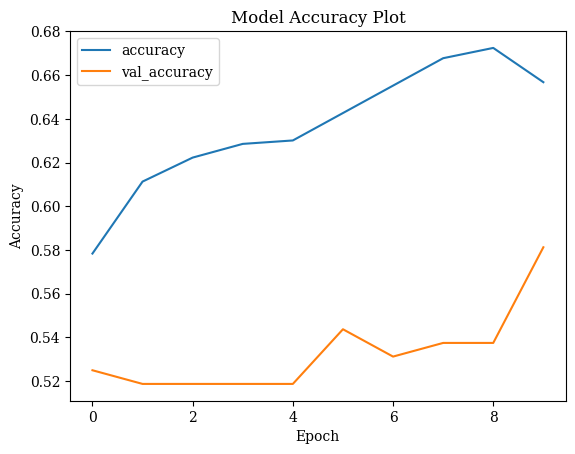

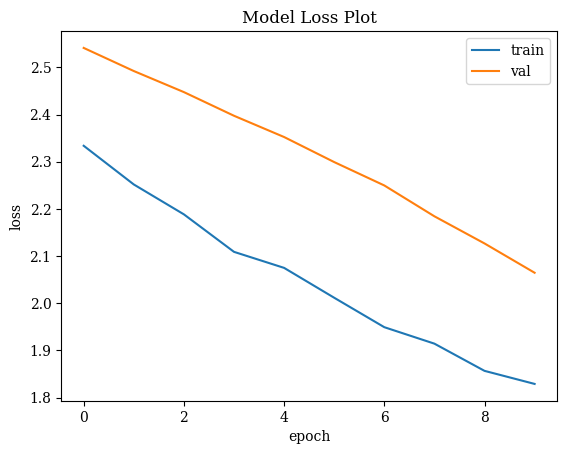

In [52]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

**Model Evaluation** <br>
In this section, the model's accuracy, size and inference time is evaluated.

In [53]:
model.save('model1.h5')
model.save('/content/drive/MyDrive/Final Project/Models/model1.h5')

In [54]:
# Evaluate prediction accuracy
test_loss, test_acc = model.evaluate(val_images,  val_labels, verbose=2)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(val_images)
executionTime = (time.time() - startTime)/len(val_images)

# Print
print('\nModel Accuracy:', test_acc*100, '%')
print("Model Size: %.2f bytes" % (get_gzipped_model_size('model1.h5')))
print("Inference Time is", executionTime, "s")


5/5 - 0s - 11ms/step - accuracy: 0.5813 - loss: 2.0647
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

Model Accuracy: 58.125001192092896 %
Model Size: 504578.00 bytes
Inference Time is 0.0032519400119781494 s


In [ ]:
#Accuracy may be misleading since the dataset being used is imbalanced, with more data on benign and malignant cases than normal cases.
#Thus we also incorporate other evaluation metrics such as recall, precision and F1-score.



**Pruning**